# Segmentation Using Snakes

**11/23/2025**

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# for reading in images: 
import skimage.data as data
from skimage.io import imread 

# for doing segmentation

import skimage.segmentation as seg 

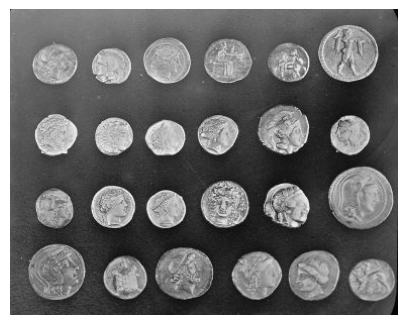

In [9]:
coinIm = data.coins()

plt.figure(figsize = (5,5))
plt.imshow(coinIm, 'gray')
plt.axis('off')
plt.show()

_Let's try using Snakes to segment on these coins._

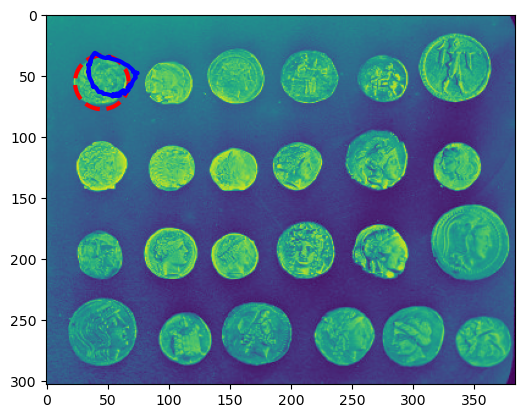

In [17]:
# use to create contours for initial snakes
def circle_points(resolution, center, radius):
    """Generate points defining a circle on an image."""
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [55,45], 22)[:-1]

snake = seg.active_contour(coinIm, points)

plt.imshow(coinIm)
plt.plot(points[:, 0], points[:, 1], '--r', lw=3)
plt.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

_Well that looks terrible, could we try using the gradient approach from Hw 8?_

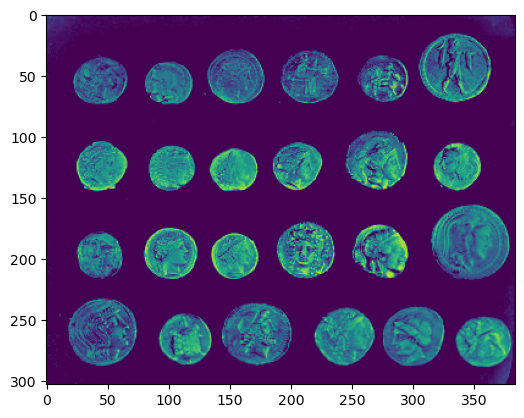

In [45]:
# cleaning up the images: 

# smooth with gaussian then take otsu: 
sigma = 35
from skimage.filters import threshold_otsu, gaussian

coinGauss = np.clip(coinIm - gaussian(coinIm, sigma = sigma, preserve_range = True), 0, None)
coinGauss *= 255 / np.max(coinGauss)
coinThresh = coinGauss > threshold_otsu(coinGauss)

plt.imshow(coinGauss)

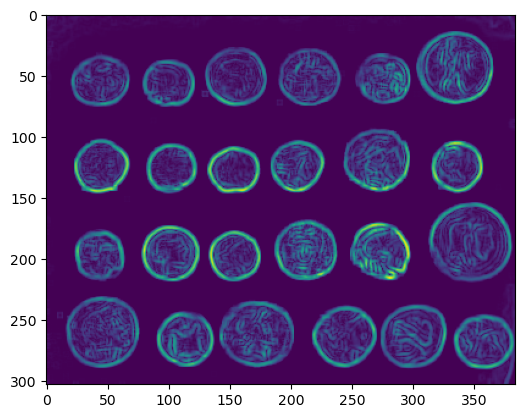

In [46]:
# setting up the gradients: 

from skimage import measure as skmeasure
from scipy import ndimage

x = np.arange(-2,3)[::-1] # reverse so negative numbers are last

sobelX, sobelY = np.meshgrid(x,x)

gradX = ndimage.convolve(input = coinGauss, weights = sobelX, mode = 'nearest')
gradY = ndimage.convolve(input = coinGauss, weights = sobelY, mode = 'nearest')

coinGrad = np.sqrt(gradX **2 + gradY ** 2)
plt.imshow(coinGrad)


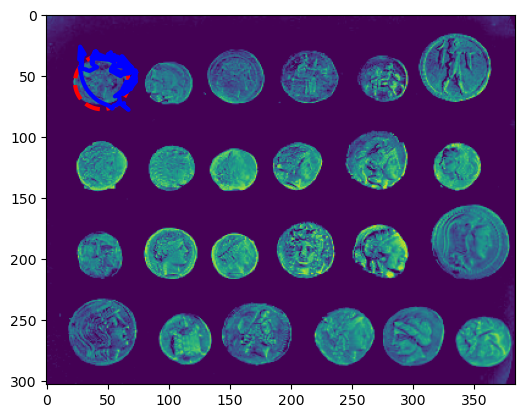

In [73]:
# let's try snakes on this!

points = circle_points(400, [55,45], 22)[:-1]

snake = seg.active_contour(coinGauss, points)

plt.imshow(coinGauss)
plt.plot(points[:, 0], points[:, 1], '--r', lw=3)
plt.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

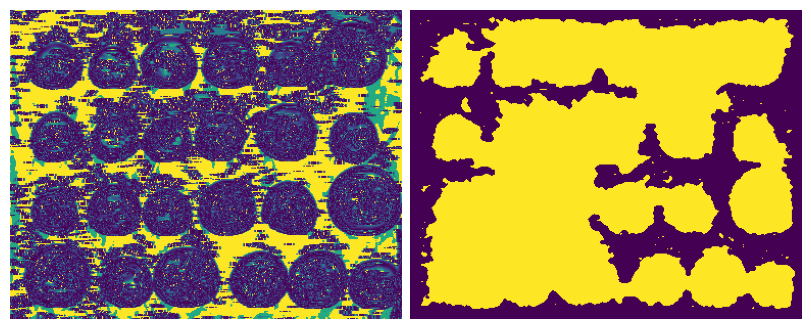

In [101]:
# following a snake tutorial: 
alpha = 1
sigma = 2
coinG = seg.inverse_gaussian_gradient(coinIm, alpha = alpha, sigma = sigma)

init_ls = np.zeros(coinIm.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
ls = seg.morphological_geodesic_active_contour(
    coinG,
    num_iter=200,
    init_level_set=init_ls,
    smoothing=1,
    balloon=-1,
    threshold=0.69,
)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,6), layout = 'constrained')

ax1.imshow(coinG)
ax2.imshow(ls)

ax1.set_axis_off()
ax2.set_axis_off()

plt.show()